1) Przypomnienie zwykłego clusteringu
* k-means
* PAM?

2) Co to jest ensamble clustering
* Generation step
* Consensus step
* Cechy dobrego modelu

3) Przykładowe modele

4) Case study

In [5]:
import numpy as np

def k_means_clustering(X, k, M):
    def initialize_centroids(X, k):
        indices = np.random.choice(X.shape[0], k, replace=False)
        return X[indices]

    def assign_clusters(X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def update_centroids(X, labels, k):
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        return centroids

    def compute_inertia(X, labels, centroids):
        inertia = 0
        for i in range(len(centroids)):
            cluster_points = X[labels == i]
            inertia += ((cluster_points - centroids[i])**2).sum()
        return inertia

    ensemble = []
    for _ in range(M):
        centroids = initialize_centroids(X, k)
        while True:
            old_centroids = centroids
            labels = assign_clusters(X, centroids)
            centroids = update_centroids(X, labels, k)
            if np.all(centroids == old_centroids):
                break
        inertia = compute_inertia(X, labels, centroids)
        ensemble.append((centroids, labels, inertia))
    
    return ensemble

# Example usage:
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [1, 4], [1, 0],
                  [4, 2], [4, 4], [4, 0]])

    k = 2
    M = 5
    ensemble = k_means_clustering(X, k, M)
    for idx, (centroids, labels, inertia) in enumerate(ensemble):
        print(f"Ensemble member {idx+1}:")
        print("Centroids:\n", centroids)
        print("Labels:\n", labels)
        print("Inertia:", inertia)
        print()


Ensemble member 1:
Centroids:
 [[4.   3.  ]
 [1.75 1.5 ]]
Labels:
 [1 1 1 0 0 1]
Inertia: 19.75

Ensemble member 2:
Centroids:
 [[1.   1.  ]
 [3.25 2.5 ]]
Labels:
 [0 1 0 1 1 1]
Inertia: 19.75

Ensemble member 3:
Centroids:
 [[1.75 2.5 ]
 [4.   1.  ]]
Labels:
 [0 0 0 1 0 1]
Inertia: 19.75

Ensemble member 4:
Centroids:
 [[4.   1.  ]
 [1.75 2.5 ]]
Labels:
 [1 1 1 0 1 0]
Inertia: 19.75

Ensemble member 5:
Centroids:
 [[1.75 1.5 ]
 [4.   3.  ]]
Labels:
 [0 0 0 1 1 0]
Inertia: 19.75



In [7]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def co_association_matrix(ensemble, n):
    co_matrix = np.zeros((n, n))
    M = len(ensemble)
    
    for centroids, labels, _ in ensemble:
        for i in range(n):
            for j in range(n):
                if labels[i] == labels[j]:
                    co_matrix[i][j] += 1

    co_matrix /= M
    return co_matrix

def agglomerative_clustering(co_matrix, theta=0.5):
    n = co_matrix.shape[0]
    clusters = [{i} for i in range(n)]
    while len(clusters) > 1:
        merged = False
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                if max(co_matrix[a, b] for a in clusters[i] for b in clusters[j]) > theta:
                    clusters[i] = clusters[i].union(clusters[j])
                    del clusters[j]
                    merged = True
                    break
            if merged:
                break
        if not merged:
            break
    return clusters

def single_linkage(Cm, Cn, dist_matrix):
    return min(dist_matrix[i, j] for i in Cm for j in Cn)

def complete_linkage(Cm, Cn, dist_matrix):
    return max(dist_matrix[i, j] for i in Cm for j in Cn)

def average_linkage(Cm, Cn, dist_matrix):
    return np.mean([dist_matrix[i, j] for i in Cm for j in Cn])

def consensus_clustering(X, ensemble, linkage='average'):
    n = X.shape[0]
    co_matrix = co_association_matrix(ensemble, n)
    
    dist_matrix = squareform(pdist(X, metric='euclidean'))
    
    if linkage == 'single':
        linkage_func = single_linkage
    elif linkage == 'complete':
        linkage_func = complete_linkage
    else:
        linkage_func = average_linkage
    
    clusters = agglomerative_clustering(co_matrix, theta=0.5)
    
    final_clusters = []
    while len(clusters) > 1:
        min_dist = float('inf')
        merge_idx = (0, 1)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                dist = linkage_func(clusters[i], clusters[j], dist_matrix)
                if dist < min_dist:
                    min_dist = dist
                    merge_idx = (i, j)
        clusters[merge_idx[0]] = clusters[merge_idx[0]].union(clusters[merge_idx[1]])
        del clusters[merge_idx[1]]
        final_clusters.append(clusters[:])
    
    return final_clusters

# Example usage:
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [1, 4], [1, 0],
                  [4, 2], [4, 4], [4, 0]])

    k = 2
    M = 5
    
    # Assuming `k_means_clustering` function from previous code
    ensemble = k_means_clustering(X, k, M)
    
    clusters = consensus_clustering(X, ensemble, linkage='average')
    print("Final clusters:", clusters)


Final clusters: [[{0, 1, 2, 3, 4, 5}]]


In [1]:
import numpy as np

def k_means_clustering(X, k, M, t=1.96, delta=0.95, delta_error=0.16):
    def initialize_centroids(X, k):
        indices = np.random.choice(X.shape[0], k, replace=False)
        return X[indices]

    def assign_clusters(X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def update_centroids(X, labels, k):
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        return centroids

    def compute_inertia(X, labels, centroids):
        inertia = 0
        for i in range(len(centroids)):
            cluster_points = X[labels == i]
            inertia += ((cluster_points - centroids[i])**2).sum()
        return inertia

    n = X.shape[0]
    sigma = np.std(X)
    n_star = (n * t**2 * sigma**2) / (delta**2 * n + t**2 * sigma**2)

    ensemble = []
    for _ in range(M):
        sample_indices = np.random.choice(n, int(n_star), replace=False)
        X_subset = X[sample_indices]
        centroids = initialize_centroids(X_subset, k)
        while True:
            old_centroids = centroids
            labels = assign_clusters(X_subset, centroids)
            centroids = update_centroids(X_subset, labels, k)
            if np.all(centroids == old_centroids):
                break
        inertia = compute_inertia(X_subset, labels, centroids)
        ensemble.append((centroids, labels, inertia))
    
    return ensemble

# Example usage:
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [1, 4], [1, 0],
                  [4, 2], [4, 4], [4, 0]])

    k = 2
    M = 5
    ensemble = k_means_clustering(X, k, M)
    for idx, (centroids, labels, inertia) in enumerate(ensemble):
        print(f"Ensemble member {idx+1}:")
        print("Centroids:\n", centroids)
        print("Labels:\n", labels)
        print("Inertia:", inertia)
        print()


Ensemble member 1:
Centroids:
 [[4. 3.]
 [1. 2.]]
Labels:
 [0 1 0]
Inertia: 2.0

Ensemble member 2:
Centroids:
 [[4. 4.]
 [1. 3.]]
Labels:
 [0 1 1]
Inertia: 2.0

Ensemble member 3:
Centroids:
 [[2.5 1. ]
 [4.  4. ]]
Labels:
 [0 1 0]
Inertia: 6.5

Ensemble member 4:
Centroids:
 [[1. 2.]
 [4. 4.]]
Labels:
 [0 1 0]
Inertia: 8.0

Ensemble member 5:
Centroids:
 [[2.5 3. ]
 [1.  0. ]]
Labels:
 [0 1 0]
Inertia: 6.5



In [4]:
import numpy as np

def dif(A, xi, xj):
    if np.issubdtype(type(xi[A]), np.number):
        return abs(xi[A] - xj[A]) / (max(xi[A], xj[A]) - min(xi[A], xj[A]))
    else:
        return 0 if xi[A] == xj[A] else 1

def W_A(A, X, m, r):
    weights = np.zeros(X.shape[1])
    for i in range(X.shape[0]):
        neighbors_same = [X[j] for j in range(X.shape[0]) if j != i and np.all(X[j, :-1] == X[i, :-1])]
        neighbors_diff = [X[j] for j in range(X.shape[0]) if j != i and not np.all(X[j, :-1] == X[i, :-1])]
        
        if len(neighbors_same) == 0:
            same_term = 0
        else:
            same_term = np.sum([dif(A, X[i], neighbor) for neighbor in neighbors_same]) / (m * r)
        
        if len(neighbors_diff) == 0:
            diff_term = 0
        else:
            diff_term = np.sum([dif(A, X[i], neighbor) for neighbor in neighbors_diff]) / (m * r * (1 - len(neighbors_diff) / (len(neighbors_same) + len(neighbors_diff))))
        
        weights[A] += same_term + diff_term
    return weights

def k_means_clustering(X, k, M, delta):
    def initialize_centroids(X, k):
        indices = np.random.choice(X.shape[0], k, replace=False)
        return X[indices]

    def assign_clusters(X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def update_centroids(X, labels, k):
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        return centroids

    def compute_inertia(X, labels, centroids):
        inertia = 0
        for i in range(len(centroids)):
            cluster_points = X[labels == i]
            inertia += ((cluster_points - centroids[i])**2).sum()
        return inertia

    ensemble = []
    for _ in range(M):
        feature_weights = np.zeros(X.shape[1])
        for A in range(X.shape[1]):
            weight = W_A(A, X, m=10, r=5)
            feature_weights[A] = np.mean(weight)
        selected_features = [i for i in range(X.shape[1]) if feature_weights[i] > delta]
        X_reduced = X[:, selected_features]
        centroids = initialize_centroids(X_reduced, k)
        while True:
            old_centroids = centroids
            labels = assign_clusters(X_reduced, centroids)
            centroids = update_centroids(X_reduced, labels, k)
            if np.all(centroids == old_centroids):
                break
        inertia = compute_inertia(X_reduced, labels, centroids)
        ensemble.append((centroids, labels, inertia))
    
    return ensemble

# Example usage:
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2, 3], [1, 4, 2], [1, 0, 4],
                  [4, 2, 3], [4, 4, 2], [4, 0, 4]])

    k = 2
    M = 5
    delta = 0.1
    ensemble = k_means_clustering(X, k, M, delta)
    for idx, (centroids, labels, inertia) in enumerate(ensemble):
        print(f"Ensemble member {idx+1}:")
        print("Centroids:\n", centroids)
        print("Labels:\n", labels)
        print("Inertia:", inertia)
        print()


Ensemble member 1:
Centroids:
 []
Labels:
 [0 0 0 0 0 0]
Inertia: 0.0

Ensemble member 2:
Centroids:
 []
Labels:
 [0 0 0 0 0 0]
Inertia: 0.0

Ensemble member 3:
Centroids:
 []
Labels:
 [0 0 0 0 0 0]
Inertia: 0.0

Ensemble member 4:
Centroids:
 []
Labels:
 [0 0 0 0 0 0]
Inertia: 0.0

Ensemble member 5:
Centroids:
 []
Labels:
 [0 0 0 0 0 0]
Inertia: 0.0



c:\users\artur\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
c:\users\artur\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice.


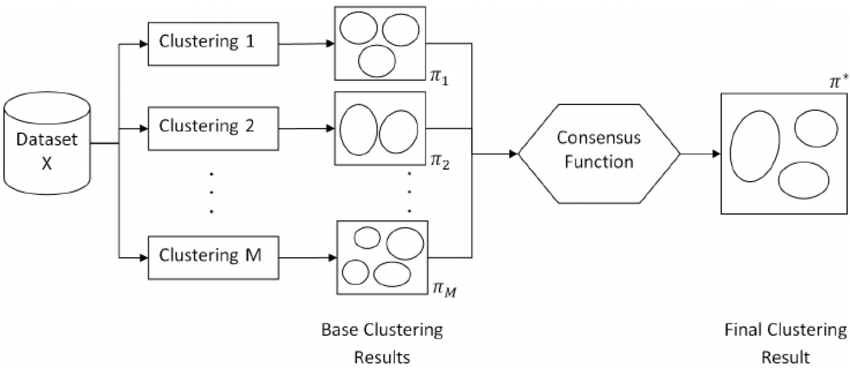